In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 1

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps
import pickle
import seaborn
import matplotlib.pyplot as plt

from openomics.multiomics import MultiOmics
from openomics.database import *
from openomics.transcriptomics import *
from openomics.genomics import *

from moge.visualization.plot_data import matrix_heatmap, plot_coo_matrix
from moge.visualization.visualize_embedding import visualize_embedding, plot_bokeh_graph
from moge.network.omics_distance import *

# Import the TCGA cancer data

In [2]:
import pickle
with open('moge/data/luad_data_openomics.pickle', 'rb') as file:
    luad_data = pickle.load(file)
#     pickle.dump(luad_data, file)

In [2]:
pd.set_option('mode.chained_assignment','raise')

In [3]:
cohort_folder = "/data/datasets/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
cohort_name = "LUAD"
luad_data = MultiOmics(cohort_name)
luad_data.add_clinical_data(clinical_data="/data/datasets/Bioinformatics_ExternalData/tcga-assembler/LUAD/clinical/nationwidechildrens.org_clinical_patient.txt")

luad_data.add_omic(MessengerRNA(cohort_name, file_path=os.path.join(cohort_folder, "gene_exp", "geneExp.txt"), 
                                gene_index_by="gene_name",
                                columns="GeneSymbol|TCGA", genes_col_name="GeneSymbol"))

luad_data.add_omic(MicroRNA(cohort_name, file_path=os.path.join(cohort_folder, "mirna/", "miRNAExp__RPM.txt"), 
                            gene_index_by="gene_name",
                            columns="GeneSymbol|TCGA", genes_col_name="GeneSymbol"))

luad_data.add_omic(LncRNA(cohort_name, file_path=os.path.join(cohort_folder, "lncrna", "TCGA-rnaexpr.tsv"), 
                          gene_index_by="gene_id",
                          columns="Gene_ID|TCGA", genes_col_name="Gene_ID"))

luad_data.build_samples()

/opt/anaconda3/lib/python3.6/site-packages/openomics/transcriptomics.py:53: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.



MessengerRNA (576, 20472)
MicroRNA (494, 1870)
LncRNA (546, 12727)


In [4]:
rnacentral = RNAcentral(path="ftp://ftp.ebi.ac.uk/pub/databases/RNAcentral/current_release/",
                       file_resources={"rnacentral_rfam_annotations.tsv":"go_annotations/rnacentral_rfam_annotations.tsv.gz",
                                      "gencode.tsv":"id_mapping/database_mappings/gencode.tsv"},
                       )

mirbase = MirBase(path="ftp://mirbase.org/pub/mirbase/CURRENT/")
ensembl = EnsemblGenes()
gencode = GENCODE(path="ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_32/",
                  file_resources={"long_noncoding_RNAs.gtf": "gencode.v32.long_noncoding_RNAs.gtf.gz",
                                  "lncRNA_transcripts.fa": "gencode.v32.lncRNA_transcripts.fa.gz",
                                  "transcripts.fa": "gencode.v32.transcripts.fa.gz"},
                  import_sequences="shortest")

# interaction datasets
lncbase = LncBase("/data/datasets/Bioinformatics_ExternalData/lncBase/", )
# targetscan = TargetScan("/data/datasets/Bioinformatics_ExternalData/TargetScan/", )
mirtarbase = MiRTarBase("/data/datasets/Bioinformatics_ExternalData/miRTarBase/", target_index="Target Gene")

Fetching file from URL: ftp://ftp.ebi.ac.uk/pub/databases/RNAcentral/current_release/ go_annotations/rnacentral_rfam_annotations.tsv.gz
Fetching file from URL: ftp://ftp.ebi.ac.uk/pub/databases/RNAcentral/current_release/ id_mapping/database_mappings/gencode.tsv
RNAcentral: ['index', 'RNAcentral id', 'database', 'transcript_id', 'species', 'RNA type', 'gene_name', 'go_id', 'Rfams']
Fetching file from URL: ftp://mirbase.org/pub/mirbase/CURRENT/ aliases.txt.gz
Fetching file from URL: ftp://mirbase.org/pub/mirbase/CURRENT/ mature.fa.gz
Fetching file from URL: ftp://ftp.ebi.ac.uk/pub/databases/RNAcentral/current_release/id_mapping/database_mappings/ mirbase.tsv
MirBase: ['mirbase id', 'RNAcentral id', 'database', 'species', 'RNA type', 'gene name', 'gene_name']


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



EnsemblGenes ['gene_id', 'gene_name', 'transcript_id', 'transcript_name', 'chromosome_name', 'transcript_start', 'transcript_end', 'transcript_length', 'gene_biotype', 'transcript_biotype', 'Rfams', 'go_id']
Fetching file from URL: ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_32/ gencode.v32.long_noncoding_RNAs.gtf.gz
Fetching file from URL: ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_32/ gencode.v32.lncRNA_transcripts.fa.gz
Fetching file from URL: ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_32/ gencode.v32.transcripts.fa.gz


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'tag', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'ont']


GENCODE: ['index', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'tag', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'ont']
LncBase ['geneId', 'geneName', 'mirna', 'species', 'cell_line', 'tissue', 'category', 'method', 'positive_negative', 'direct_indirect', 'condition']
Name: LncBase
Type: DiGraph
Number of nodes: 8212
Number of edges: 62321
Average in degree:   7.5890
Average out degree:   7.5890
Name: MiRTarBase
Type: DiGraph
Number of nodes: 17663
Number of edges: 380639
Average in degree:  21.5501
Average out degree:  21.5501


In [5]:
luad_data.LncRNA.annotate_genomics(gencode, index="gene_id", 
                                columns=['feature', 'start', 'end', 'strand', 'tag', 'havana_gene'])
luad_data.LncRNA.annotate_genomics(database=ensembl, index='gene_id', 
                                columns=['gene_name', 'transcript_id', 'transcript_name', 
                                         'chromosome_name', 'transcript_start', 'transcript_end', 'transcript_length',
                                         'Rfams', 'go_id', 'gene_biotype', 'transcript_biotype'])
luad_data.LncRNA.annotate_genomics(database=rnacentral, index='gene_name',
                                columns=['Rfams', 'go_id', 'gene_name'])
luad_data.LncRNA.annotate_sequences(gencode, index="gene_id", omic="LncRNA")

luad_data.LncRNA.annotations.info()

luad_data.MicroRNA.annotate_genomics(database=mirbase, index="gene_name", 
                                columns=['mirbase id', 'RNAcentral id', 'database'])
luad_data.MicroRNA.annotate_genomics(database=rnacentral, index="RNAcentral id",
                                columns=['transcript_id', 'RNA type', 'go_id', 'Rfams'])
luad_data.MicroRNA.annotate_genomics(database=ensembl, index='gene_name',
                                columns=['gene_name', 'transcript_id', 'transcript_name', 
                                         'chromosome_name', 'transcript_start', 'transcript_end', 'transcript_length',
                                         'Rfams', 'go_id', 'gene_biotype', 'transcript_biotype'])
luad_data.MicroRNA.annotate_sequences(mirbase, index="gene_name", omic="MicroRNA")
luad_data.MicroRNA.annotations.info()

luad_data.MessengerRNA.annotate_genomics(database=rnacentral, index="gene_name",
                                columns=['gene_name', 'transcript_id', 'RNA type', 'go_id', 'Rfams'])
luad_data.MessengerRNA.annotate_genomics(database=ensembl, index='gene_name',
                                columns=['gene_id', 'transcript_id', 'transcript_name', 
                                         'chromosome_name', 'transcript_start', 'transcript_end', 'transcript_length',
                                         'Rfams', 'go_id', 'gene_biotype', 'transcript_biotype'])
luad_data.MessengerRNA.annotate_sequences(gencode, index="gene_name", omic="MessengerRNA")
luad_data.MessengerRNA.annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12727 entries, ENSG00000005206 to ENSGR0000270726
Data columns (total 18 columns):
gene_name              11848 non-null object
feature                11586 non-null object
start                  11586 non-null object
end                    11586 non-null object
strand                 11586 non-null object
tag                    11586 non-null object
havana_gene            11586 non-null object
transcript_id          11848 non-null object
transcript_name        11848 non-null object
chromosome_name        11848 non-null object
transcript_start       11848 non-null object
transcript_end         11848 non-null object
transcript_length      11848 non-null object
Rfams                  150 non-null object
go_id                  216 non-null object
gene_biotype           11848 non-null object
transcript_biotype     11848 non-null object
Transcript sequence    11586 non-null object
dtypes: object(18)
memory usage: 1.8+ MB
<class 'pandas.core.frame

In [6]:
LNC = luad_data.LncRNA.get_annotations()
MIR = luad_data.MicroRNA.get_annotations()
GE = luad_data.MessengerRNA.get_annotations()
print(GE.columns)
print(MIR.columns)
print(LNC.columns)

Index(['transcript_id', 'RNA type', 'go_id', 'Rfams', 'gene_id',
       'transcript_name', 'chromosome_name', 'transcript_start',
       'transcript_end', 'transcript_length', 'gene_biotype',
       'transcript_biotype', 'Transcript sequence'],
      dtype='object')
Index(['RNAcentral id', 'mirbase id', 'database', 'transcript_id', 'RNA type',
       'go_id', 'Rfams', 'transcript_name', 'chromosome_name',
       'transcript_start', 'transcript_end', 'transcript_length',
       'gene_biotype', 'transcript_biotype', 'Transcript sequence'],
      dtype='object')
Index(['gene_name', 'feature', 'start', 'end', 'strand', 'tag', 'havana_gene',
       'transcript_id', 'transcript_name', 'chromosome_name',
       'transcript_start', 'transcript_end', 'transcript_length', 'Rfams',
       'go_id', 'gene_biotype', 'transcript_biotype', 'Transcript sequence'],
      dtype='object')


In [10]:
gene_exp_medians = pd.read_csv("/data/datasets/Bioinformatics_ExternalData/GTEx/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct", sep='\t', header=1, skiprows=1)
gene_exp_medians.index = gene_exp_medians["Description"]
gene_exp_medians.drop("gene_id", axis=1, inplace=True)
gene_exp_medians.drop("Description", axis=1, inplace=True)
gene_exp_medians.index.rename("gene_id", inplace=True)

In [11]:
transcript_exp_medians = pd.read_csv("/data/datasets/Bioinformatics_ExternalData/GTEx/GTEx_Analysis_2016-01-15_v7_RSEMv1.2.22_transcript_max_tpm.tsv", sep='\t')
transcript_exp_medians.index = transcript_exp_medians["gene_id"]
transcript_exp_medians.drop("gene_id", axis=1, inplace=True)
# transcript_exp_medians = transcript_exp_medians.T
transcript_exp_medians.index = transcript_exp_medians.index.str.replace("[.].*", "")

In [17]:
mir_gene_id_to_name = pd.Series(MIR["mirbase id"].values, index=MIR["transcript_id"]).to_dict()
lnc_gene_id_to_name = pd.Series(LNC.index.values, index=LNC.index).to_dict()

In [18]:
GE_tissue_exp = gene_exp_medians[gene_exp_medians.index.isin(GE.index)]
GE_tissue_exp = GE_tissue_exp[~GE_tissue_exp.index.duplicated(keep="first")]
GE_tissue_exp.shape

(18939, 53)

In [19]:
LNC_tissue_exp = transcript_exp_medians[transcript_exp_medians.index.isin(lnc_gene_id_to_name.keys())]
LNC_tissue_exp.index = LNC_tissue_exp.index.map(lnc_gene_id_to_name)
LNC_tissue_exp.shape

(12727, 53)

In [24]:
MIR_tissue_exp = transcript_exp_medians[transcript_exp_medians.index.isin(mir_gene_id_to_name.keys())]
MIR_tissue_exp["transcript_id"] = MIR_tissue_exp.index
MIR_tissue_exp["transcript_id"].replace(mir_gene_id_to_name, inplace=True)
MIR_tissue_exp.set_index("transcript_id", inplace=True)
# MIR_tissue_exp.drop("transcript_id", axis=1, inplace=True)
MIR_tissue_exp.shape

(0, 53)

# Test nodes affinities features

In [26]:
# node_list = GE[GE["gene_family"].notnull()].index[0:1000]
node_list = LNC.index
correlation_dist = compute_expression_correlation_dists(luad_data, modalities=["LncRNA"],
                                                        node_list=node_list, absolute_corr=True,
                                                        squareform=False, tissue_expression=LNC_tissue_exp)
affinity = compute_annotation_affinities(LNC, node_list=node_list,
                features=["locus_type"], 
#                features=["Family", "tag", "Strand", "Chromosome"], 
                                         correlation_dist=correlation_dist,
                                        nanmean=False, 
#                                          weights=[1, 1, 0.5, 0.5, 5],
                                        )


TypeError: load_data() got an unexpected keyword argument 'modalities'

(80714865,)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:17: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(degrees, k_power))
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:18: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(degrees, k_power)))


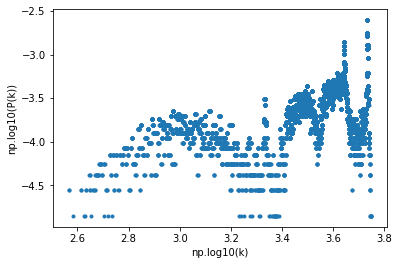

0.32519149692118055

In [32]:
from moge.evaluation.utils import get_scalefree_fit_score
from scipy.sparse import triu
from scipy.spatial.distance import squareform

affinities = squareform(affinity, checks=False)
print(affinities.shape)
adj_list = np.nansum(affinity, axis=1)
# adj_list = affinities[np.where(~np.isnan(affinities.data))].reshape((-1))

get_scalefree_fit_score(adj_list, plot=True)

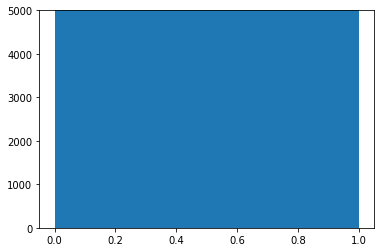

In [33]:
plt.hist(affinity[np.where(~np.isnan(affinity))].reshape((-1)), bins=500)
plt.ylim(top=5000)
plt.show()

In [34]:
threshold=0.99
print("threshold at", threshold,":",(affinity > threshold).sum())
# print("threshold at", threshold,":",(affinity < 0.01).sum())

threshold at 0.99 : 772160


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [ ]:
# matrix_heatmap(np.array(affinity>threshold, dtype=float))
matrix_heatmap(affinity)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


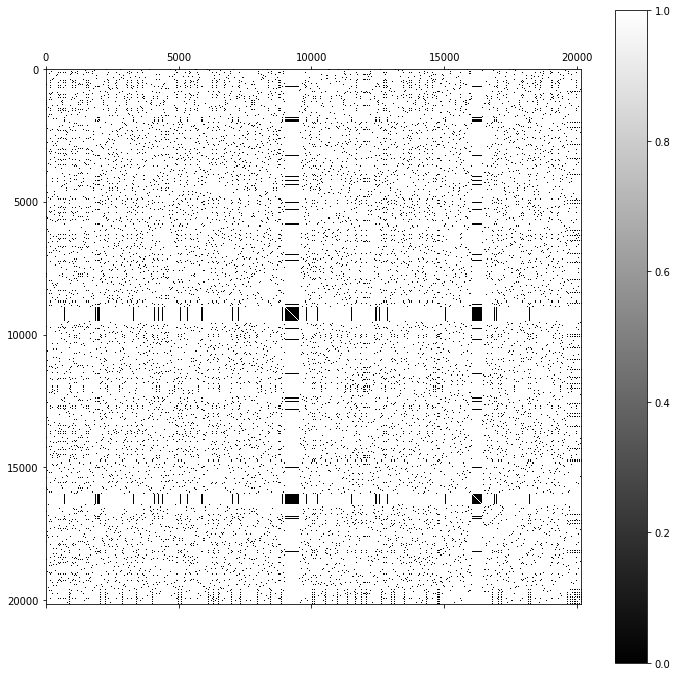

In [25]:
matrix_heatmap(np.array(affinity<0.01, dtype=float))

# Heterogeneous Network

In [2]:
import pickle
with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
    luad_data = pickle.load(file)
#     pickle.dump(luad_data, file)

In [3]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network = HeterogeneousNetwork(modalities=["MicroRNA", "MessengerRNA", "LncRNA"], multi_omics_data=luad_data)

MicroRNA  nodes: 1870
MessengerRNA  nodes: 20472
LncRNA  nodes: 12727
Total nodes: 35069
Genes info columns: ['transcript_id', 'go_id', 'Rfams', 'transcript_name', 'chromosome_name', 'transcript_start', 'transcript_end', 'transcript_length', 'gene_biotype', 'transcript_biotype', 'Transcript sequence']


## Write node labels to file

In [4]:
from moge.network.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE", "LNC"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_disease_dummies.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE", "LNC"], remove_na=True, sep="\t",
#                           get_dummies=True)

# Add Attribute Affinity Positive Edges

In [ ]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
    similarity_threshold=0.80, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Disease association"],
    weights=[1, 1],
    compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (20157,)
Dice distance


In [ ]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
    similarity_threshold=0.85, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=False,
    features=["locus_type", "gene_family_id", "location"], 
    weights=[0.5, 1, 0.5, 1],
    compute_correlation=True, tissue_expression=GE_tissue_exp)

In [ ]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Disease association"], 
    compute_correlation=False)

In [ ]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["Family", "Rfams"], 
    compute_correlation=True, tissue_expression=MIR_tissue_exp)

In [ ]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
    similarity_threshold=0.90, dissimilarity_threshold=0.1,
    negative_sampling_ratio=5.0, 
    nanmean=False,
    features=["locus_type", "Transcript type", "tag", "Strand", "Chromosome"],
    weights=[1, 1, 0.5, 0.5, 1, 1],
    compute_correlation=True, tissue_expression=LNC_tissue_exp)

In [ ]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Family", "Disease association"], 
    compute_correlation=False)

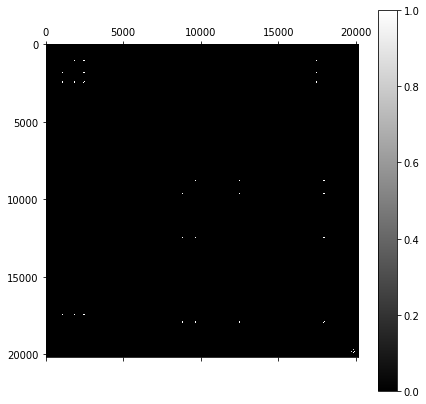

In [5]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["GE"]).todense(),
              figsize=(7,7))

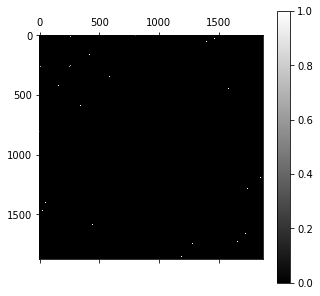

In [6]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["MIR"]).todense(),
              figsize=(5,5))

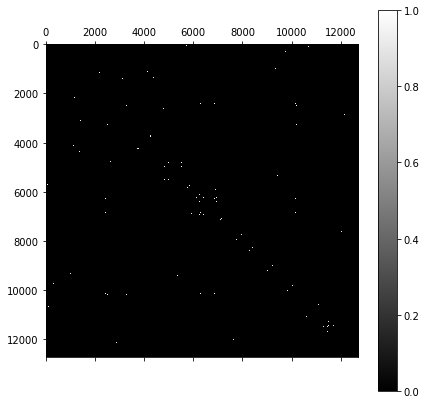

In [7]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["LNC"]).todense(),
              figsize=(7,7))

In [4]:
# IMPORT Affinity Edgelist
network.import_edgelist_file(
    file="moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_TissueExp_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
#     file="moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
    is_directed=False)

In [ ]:
# WRITE Affinity Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE", "LNC"], edge_type="u"), 
#                   "moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_TissueExp_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
#                   data=True)

# Add Attribute Affinity NEGATIVE Edges between cross-modals

In [11]:
u_n_size = 10000
network.add_sampled_negative_edges(u_n_size, modalities=["GE", "MIR"])
network.add_sampled_negative_edges(u_n_size*2, modalities=["GE", "LNC"])
network.add_sampled_negative_edges(u_n_size, modalities=["LNC", "MIR"])

Number of negative sampled edges between ['GE', 'MIR'] added: 10000
Number of negative sampled edges between ['GE', 'LNC'] added: 20000
Number of negative sampled edges between ['LNC', 'MIR'] added: 10000


# miRTarBase

In [7]:
mirtarbase_new = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=True, data=False, rename_dict=case_relabel)
mirtarbase_old = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False, data=False, rename_dict=case_relabel)
mirtarbase_diff = list(set(mirtarbase_new) - set(mirtarbase_old))
len(mirtarbase_diff)

64749

In [8]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False),
#                                                                                                        rename_dict=case_relabel), 
                                        modalities=["MIR", "GE"], correlation_weights=False, threshold=0.20,
                                        database="miRTarBase")

Adding edgelist with 1807 total unique MIR genes (source), but only matching 1618 nodes
Adding edgelist with 14894 total unique GE genes (target), but only matching 14014 nodes
319943 edges added.


# StarBase mRNA-RNA

In [13]:
starbase_new = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=1, data=False)
starbase_old = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=2, data=False)
starbase_diff = list(set(starbase_new) - set(starbase_old))
len(starbase_diff)

1516287

In [8]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_RNA_interactions(),
                                        modalities=["LNC", "GE"], correlation_weights=False, threshold=0.2,
                                        database="starBase")

Adding edgelist with 359 total unique LNC genes (source), but only matching 295 nodes
Adding edgelist with 10016 total unique GE genes (target), but only matching 6470 nodes
20600 edges added.


/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:301: FutureWarning: read_table is deprecated, use read_csv instead.
  "pairGeneType", "interactionNum", 'expNum', "FreeEnergy"])


# BioGRID

In [9]:
biogrid_new = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, rename_dict=case_relabel,
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.5.169.tab2.txt')
biogrid_old = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, rename_dict=case_relabel,
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.4.162.tab2.txt')
biogrid_diff = list(set(biogrid_new) - set(biogrid_old))
len(biogrid_diff)

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


33522

In [9]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.GE.get_BioGRID_GRN_edgelist(biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.4.162.tab2.txt'),
#                                                                                        rename_dict=case_relabel),
                                        modalities=["GE", "GE"], correlation_weights=False, threshold=0.2,
                                        database="BioGRID")

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Adding edgelist with 13318 total unique GE genes (source), but only matching 12768 nodes
Adding edgelist with 19429 total unique GE genes (target), but only matching 14972 nodes
313724 edges added.


# NPInter

In [11]:
from moge.network.heterogeneous_network import get_rename_dict
noncode_rename_dict = pd.Series(luad_data.LNC.noncode_func_df["Gene Name"].values,
     index=luad_data.LNC.noncode_func_df["NONCODE Gene ID"].str.split(".", expand=True)[0]).to_dict()
noncode_rename_dict = {k: noncode_rename_dict[k] for k in noncode_rename_dict if type(noncode_rename_dict[k])!=float}

lncbase_rename_dict = get_rename_dict(luad_data.LNC.get_genes_info(), "Gene ID")
lncbase_rename_dict.update(noncode_rename_dict)

In [12]:
# lncbase_rename_dict.update(case_relabel)

NameError: name 'case_relabel' is not defined

In [13]:
npinter_new = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=True, data=False,
                                                                                 rename_dict=lncbase_rename_dict)
npinter_old = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False, data=False,
                                                                                 rename_dict=lncbase_rename_dict)
npinter_diff = list(set(npinter_new) - set(npinter_old))
len(npinter_diff)

123439

In [10]:
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False), 
#                                                                                                                       rename_dict=lncbase_rename_dict),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="NPInter")

Adding edgelist with 727 total unique LNC genes (source), but only matching 12 nodes
Adding edgelist with 5659 total unique GE genes (target), but only matching 5023 nodes
85335 edges added.


# lncBase

In [15]:
lncbase_new = luad_data.LNC.get_lncBase_miRNA_lncRNA_predicted_interactions_edgelist(rename_dict=lncbase_rename_dict,
                                                                                     data=False)
lncbase_old = luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(rename_dict=lncbase_rename_dict, 
                                                                           data=False)
lncbase_diff = list(set(lncbase_new) - set(lncbase_old))
print(len(lncbase_diff))

337031


In [14]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
#                                          modalities=["LNC", "MIR"], correlation_weights=False, threshold=0.20,
#                                         database="lncRNome")

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(rename_dict=lncbase_rename_dict),
                                         modalities=["MIR", "LNC"], correlation_weights=False, threshold=0.20,
                                        database="lncBase")


# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_LncReg_lncRNA_RNA_regulatory_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="LncReg")

Adding edgelist with 702 total unique MIR genes (source), but only matching 631 nodes
Adding edgelist with 7235 total unique LNC genes (target), but only matching 2535 nodes
60186 edges added.


# lncrna2target

In [17]:
lnc2tar_low = luad_data.LNC.get_lncrna2target_low_throughput_interactions(data=False, rename_dict=lncbase_rename_dict)
lnc2tar_high = luad_data.LNC.get_lncrna2target_high_throughput_interactions(data=False, rename_dict=lncbase_rename_dict)
lnc2tar_diff = list(set(lnc2tar_high) - set(lnc2tar_low))
len(lnc2tar_diff)

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


65624

In [15]:
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncrna2target_high_throughput_interactions(rename_dict=lncbase_rename_dict),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="lncrna2target")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncrna2target_low_throughput_interactions(rename_dict=lncbase_rename_dict),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncrna2target")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRInter_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncRInter")

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Adding edgelist with 61 total unique LNC genes (source), but only matching 17 nodes
Adding edgelist with 28866 total unique GE genes (target), but only matching 16337 nodes
65655 edges added.


In [ ]:
npinter_val = {(u,v) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]=="NPInter"}
len(npinter_val)
npinter_train = {(u,v) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]=="NPInter"}
len(npinter_train)
len(lncbase_train & l2t_val)

# Filter the edges

In [3]:
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.train_v2.pickle', 
          'rb') as file:
    network = pickle.load(file)

In [36]:
edges_bunch = [(u,v,d) for u,v,d in network.G.edges(data=True) if ("database" in d and 
                                                                   d["database"]=="miRTarBase")]
print(len(edges_bunch))

319246


In [37]:
database_nodes = nx.DiGraph(incoming_graph_data=edges_bunch).nodes()
database_nodes = list(database_nodes)
len(database_nodes)

16695

In [38]:
edges_bunch = [(u,v,d) for u,v,d in network.G.edges(nbunch=database_nodes, data=True) \
               if d["type"] == 'u' or d["type"] == "u_n" or ("database" in d and d["database"]=="miRTarBase")]
print(len(edges_bunch))

664279


In [39]:
network.G.clear()
network.G.add_edges_from(edges_bunch)

# Filter the node_list

In [32]:
node_pairs = {(node1, node2) for node1 in network.G.node for node2 in network.G.node if\
              node1!=node2 and node2.lower()==node1.lower()}
len(node_pairs)

5746

In [6]:
case_relabel = {}
for u,v in node_pairs:
    if v in network.genes_info.index:
        case_relabel[u] = v
    elif u in network.genes_info.index:
        case_relabel[v] = u
len(case_relabel)

NameError: name 'node_pairs' is not defined

In [19]:
len([node for node in network.G.nodes if node not in network.genes_info.index])

24271

In [16]:
isolates = list(nx.isolates(network.G))
len(isolates)

10499

In [17]:
bad_nodes = [node for node in network.get_node_list() if node is None or \
             type(node) != str or \
             node == "" or \
             " " in node
            ]
len(bad_nodes)

2

In [18]:
network.G.remove_nodes_from(isolates)
network.G.remove_nodes_from(bad_nodes)
network.G_u.remove_nodes_from(bad_nodes)

In [19]:
network.nodes["GE"] = [node for node in network.nodes["GE"] if node in network.G.nodes()]
network.nodes["LNC"] = [node for node in network.nodes["LNC"] if node in network.G.nodes()]
network.nodes["MIR"] = [node for node in network.nodes["MIR"] if node in network.G.nodes()]

In [20]:
network.G.number_of_nodes(), network.G.number_of_edges()

(45179, 844144)

In [21]:
len(network.node_list)

55678

In [22]:
# WRITE/READ FULL network
import pickle
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target_cotissexp.train.pickle', 
          'wb') as file:
    pickle.dump(network, file)
#     network = pickle.load(file)

# Split train-test by edges

In [45]:
import pickle
# WRITE READ network
with open('moge/data/LMN_future_recall/Predict/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.test.pickle', 'rb') as file:
    network = pickle.load(file)

In [27]:
from moge.evaluation.utils import split_train_test_edges

network_train, test_edges, val_edges = split_train_test_edges(network, network.node_list, 
#                                                                            databases=,
                                                          test_frac=.00, val_frac=.20, edge_types=["d"], 
                                                          seed=0, verbose=True)

preprocessing...
edges_to_remove 345875
edges_to_remove (after MST) 345875
test_edges_size 0
val_edges_size 69175
Removed 0 test, and 69175 val, type ['d'] edges


In [28]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581
MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581


# Split train-test by nodes

In [ ]:
from moge.evaluation.utils import split_train_test_nodes

network_train, test_edges, val_edges, test_nodes, val_nodes = split_train_test_nodes(network, network.nodes["LNC"],
                                                          test_frac=.00, val_frac=.10, edge_types=["d"], 
                                                          seed=0, verbose=True)

In [ ]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.val_node_list = test_nodes
network_val.val_node_list = val_nodes
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)
len(network_test.node_list), len(network_val.node_list)

In [ ]:
network_train.G.number_of_edges()

# Write Network Data to Files

In [29]:
# WRITE
import pickle
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.pickle', 'wb') as file:
    pickle.dump(network_train, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_test.pickle', 'wb') as file:
    pickle.dump(network_test, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_val.pickle', 'wb') as file:
    pickle.dump(network_val, file)

In [30]:
# WRITE Edgelist
nx.write_edgelist(network_train.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.full.edgelist", 
                  data=False)

In [25]:
# Write edgelist interactions only
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(node_list=network.node_list)),
                  "moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.interactions.latest.edgelist",
                  data=False)

In [11]:
# Write edgelist interactions only, database specific
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(edge_types=["d"], 
                                                                    databases=["BioGRID"], 
                                                                    node_list=network.node_list)),
                  "moge/data/LMN_future_recall/TRAIN/Interactions_Only/LNC/lmn_train.BioGRID.interactions.edgelist",
                  data=False)

## Network Info & Visualizations

In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))

In [ ]:
csr_un = network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list)
csr_d = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)

In [ ]:
matrix_heatmap(csr_un.toarray())

In [ ]:
matrix_heatmap(csr_u.toarray())

In [ ]:
matrix_heatmap(csr_d.toarray())